In [145]:
import matplotlib.pyplot as plt;
import numpy as np;
import astropy as apy;
from planets import CandidateTable, PlanetTable;
from stars import StarTable;
from matplotlib import cm

In [146]:
# in scenarios where the quantity has its errorbars
# reported with it, useful to use this mask to get
# just the value
emsk = (slice(None), 0)

In [147]:
# load stellar data
star_table = StarTable(verbose=0)
star_table.loadTable('stars.tbl')
star_table.loadTable('sup_stars.tbl')

Text(0.5, 1.0, '850 Stars')

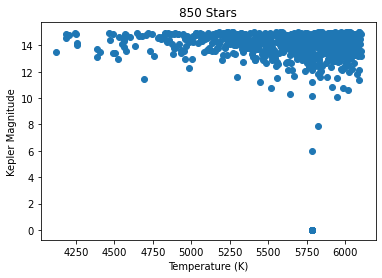

In [148]:
# make cuts
star_table.magCut()
star_table.loggCut()
star_table.tempCut()
temp = star_table.getMaskedData('temperature')
mag = star_table.getMaskedData('mag')
plt.scatter(temp[emsk], mag)
plt.ylabel('Kepler Magnitude')
plt.xlabel('Temperature (K)')
plt.title("%d Stars"%len(mag))

In [149]:
# load planetary data
pl_table = PlanetTable(verbose=0)
can_table = CandidateTable(verbose=0)

pl_table.loadTable('confirmed.tbl',load_other=["pl_orbsmax","st_rad"])
can_table.loadTable('candidate.tbl',load_other=["koi_sma","koi_srad"])

In [150]:
can_table.magCut()
can_table.periodCut()
can_table.loggCut()
can_table.radiusCut()
can_table.tempCut()

pl_table.magCut()
pl_table.loggCut()
pl_table.tempCut()
pl_table.periodCut()
pl_table.radiusCut()

In [151]:
plan_p = pl_table.getMaskedData('period')
cand_p = can_table.getMaskedData('period')
plan_r = pl_table.getMaskedData('radius')
cand_r = can_table.getMaskedData('radius')
dope = can_table.getMaskedData('koi_sma')[emsk]
dape = pl_table.getMaskedData('pl_orbsmax')[emsk]
#print(len(cand_r[emsk]))
#print(len(dope))
#print(np.sum(np.where(dope != 0.,1,0)))

In [153]:
#defining bins for planet radius
radius_bins = np.logspace(np.log10(2.),np.log10(22.627416998),num=8)
#print(radius_bins)
rbinnage = np.digitize(plan_r[emsk],radius_bins)
#print(rbinnage)

Text(0.5, 0, 'period (days)')

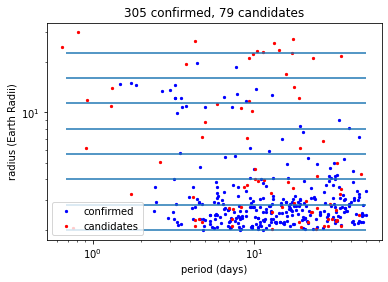

In [154]:
plt.scatter(plan_p[emsk], plan_r[emsk], color = 'blue', label = 'confirmed', s = 5)
plt.scatter(cand_p[emsk], cand_r[emsk], color = 'red', label = 'candidates', s = 5)
plt.hlines(radius_bins,xmin=0.68,xmax = 50.)
#plt.vlines(period_bins,ymin=1.,ymax=23.)
plt.legend()
plt.loglog()
plt.title('%d confirmed, %d candidates'%(len(plan_p), len(cand_p)))
plt.ylabel('radius (Earth Radii)')
plt.xlabel('period (days)')

In [156]:
#marginalize over radius, give me indices
rbin01 = np.argwhere(rbinnage == 1)
rbin02 = np.argwhere(rbinnage == 2)
rbin03 = np.argwhere(rbinnage == 3)
rbin04 = np.argwhere(rbinnage == 4)
rbin05 = np.argwhere(rbinnage == 5)
rbin06 = np.argwhere(rbinnage == 6)
rbin07 = np.argwhere(rbinnage == 7)
rbin08 = np.argwhere(rbinnage == 8)
rbin09 = np.argwhere(rbinnage == 9)  #probably empty, thought we had 10 r bins for some reason
rbin10 = np.argwhere(rbinnage == 10) #etc.
rbins = [rbin01,rbin02,rbin03,rbin04,rbin05,rbin06,rbin07,rbin08,rbin09] #excluded rbin10, empty
#print(rbin09)
#print(type(plan_r[emsk][rbin09][0]))

In [157]:
### organizing data for analysis
### need to get for each planet: semi-major axis, star radius, number of stars (fixed?),
nstars = len(mag)
sma_p = pl_table.getMaskedData('pl_orbsmax')[emsk]
str_p = pl_table.getMaskedData('st_rad')[emsk]
rad_p = pl_table.getMaskedData('radius')[emsk]
sma_c = can_table.getMaskedData('koi_sma')[emsk]
str_c = can_table.getMaskedData('koi_srad')[emsk]
rad_c = can_table.getMaskedData('radius')[emsk]
per_p = pl_table.getMaskedData('period')[emsk]
per_c = can_table.getMaskedData('period')[emsk]
fcell_wholeset = []
for i in range(len(rbins)):  #iterate over the bins
    indexs = rbins[i]
    fcell_thisbin = []
    for j in range(len(indexs)):
        fcell_thisbin.append(np.array([sma_p[indexs[j][0]],str_p[indexs[j][0]],rad_p[indexs[j][0]]],dtype=float))
        pass
    meanR = np.mean(rad_p[indexs])
    fcell_wholeset.append((fcell_thisbin,meanR))
    pass
xxx = np.array(fcell_wholeset,dtype=object)
print(xxx[6])
#xxx hold relevant date for all planets
#xxx[i] specifies a radius bin
#xxx[i] has 2 components: tuple(semi major axis, star radius) and planet radius

[list([array([ 0.0553,  1.48  , 19.661 ]), array([ 0.0769,  1.05  , 18.49  ])])
 19.075499999999998]


/home/antoine/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antoine/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [158]:
def f_cell(onebin):
    #onebin should hold all planets in a bin
    #onebin[i] holds relevant parameters of planet i of cell dat: a, Rstar
    #onebin[i][j]
    #would also include number of stars associated with planet i, but alas
    #will sum over planets
    global nstars
    #print(onebin)
    #onebin, R_p = onebin
    pj = []
    for i in range(len(onebin)):
        pj.append(onebin[i][1] / onebin[i][0])
    pj = np.array(pj)
    #print(onebin)
    expres = 1/pj / nstars    #
    return np.sum(expres)
#
def n_nd(onebin):
    #onebin planet data
    #will call f_cell, needs: a, Rstar
    n_pl = len(onebin)
    f_c = f_cell(onebin)
    return n_pl/f_c - n_pl
#
def likelihood(allbins,parameter_grid):
    #allbins hold data from all radius bins
    #allbins[i] holds data for radius bin i
    k_R, alph = parameter_grid
    expres = []
    for i in range(len(allbins)): #loop through all the bins
        r_bin, R_p = allbins[i]
        n_pl = len(r_bin)
        n_np = n_nd(r_bin)
        expres.append(np.where( 1-k_R * R_p ** alph <= 0, 0, n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * np.log(1 - k_R * R_p ** alph)))
        #expres.append(n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * np.log(1 - k_R * R_p ** alph))
        #expres.append(n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * 1)
    expres = np.array(expres)
    print(expres.shape)
    return np.sum(expres,axis=0)

In [161]:
krs = np.linspace(0.5,6,num=50)
als = np.linspace(-2.5,3,num=50)
gridd = np.meshgrid(krs,als)
#print(xxx)
door = likelihood(xxx,gridd)
print(door)
#i promise, at one point this spit out actual numbers but no more

(9, 50, 50)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/tmp/ipykernel_20404/3959717448.py:34: RuntimeWarning: invalid value encountered in log
  expres.append(np.where( 1-k_R * R_p ** alph <= 0, 0, n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * np.log(1 - k_R * R_p ** alph)))
/tmp/ipykernel_20404/3959717448.py:23: RuntimeWarning: invalid value encountered in double_scalars
  return n_pl/f_c - n_pl


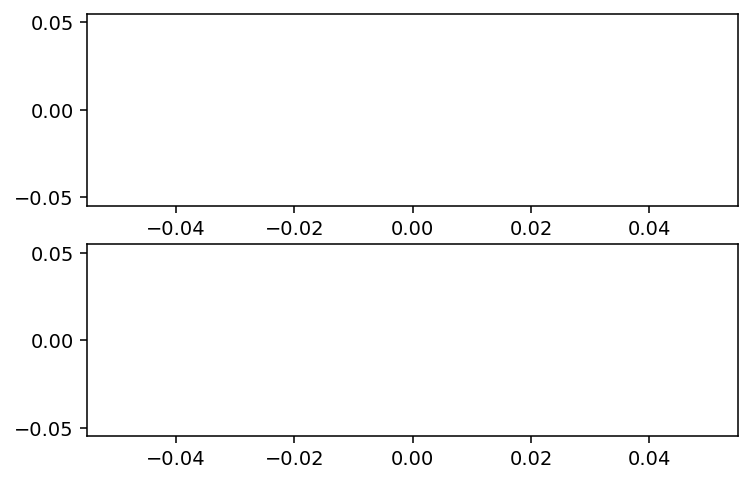

In [163]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.figsize = (8,4.5)
fig.dpi=140
#
ax1.plot(krs,door[30,:])
ax2.plot(als,door[:,30])
plt.show()

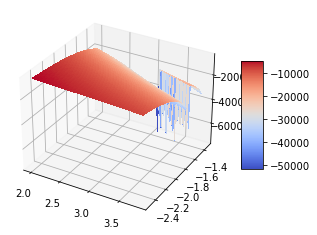

In [23]:
#copied most of this from the plot_surface() documentation
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(gridd[0], gridd[1], door, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [164]:
### by orbital period
### separating planets by plantary radius
#rad_bins2 = np.logspace(np.log10(2),np.log10(8),num=3)
rbinnage2 = np.digitize(plan_r[emsk],[2,4,8,32])
#print(rbinnage2)
#
sbin01 = np.argwhere(rbinnage2 == 1)
sbin02 = np.argwhere(rbinnage2 == 2)
sbin03 = np.argwhere(rbinnage2 == 3)
#print(sbin01[0][0])
#
radius_set1 = [(sma_p[sbin01[i][0]], str_p[sbin01[i][0]], rad_p[sbin01[i][0]], per_p[sbin01[i][0]]) for i in range(len(sbin01))]
radius_set2 = [(sma_p[sbin02[i][0]], str_p[sbin02[i][0]], rad_p[sbin02[i][0]], per_p[sbin02[i][0]]) for i in range(len(sbin02))]
radius_set3 = [(sma_p[sbin03[i][0]], str_p[sbin03[i][0]], rad_p[sbin03[i][0]], per_p[sbin03[i][0]]) for i in range(len(sbin03))]
radius_set1 = np.array(radius_set1,dtype=object) #2-4 E-radii
radius_set2 = np.array(radius_set2,dtype=object) #4-8
radius_set3 = np.array(radius_set3,dtype=object) #8-32
#print(radius_set3)
#print( radius_set3[np.logical_and(radius_set3[:,3] >= period_bins[2], radius_set3[:,3] < period_bins[3])] )

period_bins = np.logspace(np.log10(0.683990378),np.log10(50),num=9)
print(period_bins)
pbinnage = np.digitize(plan_p[emsk],period_bins)
print(pbinnage)
#
pbin01 = np.argwhere(pbinnage == 1)
pbin02 = np.argwhere(pbinnage == 2)
pbin03 = np.argwhere(pbinnage == 3)
pbin04 = np.argwhere(pbinnage == 4)
pbin05 = np.argwhere(pbinnage == 5)
pbin06 = np.argwhere(pbinnage == 6)
pbin07 = np.argwhere(pbinnage == 7)
pbin08 = np.argwhere(pbinnage == 8)
pbin09 = np.argwhere(pbinnage == 9)
pbins = [pbin01,pbin02,pbin03,pbin04,pbin05,pbin06,pbin07,pbin08,pbin09]

[ 0.68399038  1.16960709  2.          3.41995189  5.84803547 10.
 17.09975946 29.24017738 50.        ]
[4 6 7 6 6 7 8 8 8 5 7 5 7 3 4 3 8 4 6 7 8 7 7 8 6 4 8 6 7 8 8 4 7 4 5 6 8
 6 7 7 7 8 8 5 4 6 6 6 6 8 4 5 7 7 6 7 5 6 8 5 8 6 2 5 6 4 6 3 5 6 8 5 6 8
 6 7 5 7 5 6 8 4 6 6 7 7 5 7 5 7 7 5 8 7 8 7 6 5 7 3 4 6 5 6 8 3 5 8 4 8 5
 7 8 4 7 8 4 6 7 4 6 7 5 6 4 5 4 6 5 6 8 6 8 4 6 5 3 7 8 5 5 6 6 5 6 7 5 6
 8 5 4 4 5 7 5 7 8 4 5 7 5 6 5 7 6 8 6 6 7 4 6 7 5 3 4 6 3 5 7 6 8 5 8 8 5
 6 6 8 6 8 5 5 7 7 4 6 6 5 5 4 6 8 6 6 8 7 8 7 8 6 8 4 5 6 7 7 5 8 5 8 8 8
 3 4 5 6 5 7 8 5 6 6 8 5 4 4 6 5 8 6 4 6 8 6 7 8 8 5 5 7 6 7 8 5 7 7 5 7 8
 6 8 8 5 6 6 7 7 7 3 6 8 2 2 5 3 3 4 3 6 4 3 8 6 3 5 8 8 5 8 3 5 7 6 6 5 5
 5 4 5 5 5 7 8 7 8]


In [167]:
##orbital period analysis given a radius_set
def p_fcell(radset):
    #radset is a N,3 array where N in number of planets in the radius bin
    #
    global nstars
    global period_bins
    perbin = []
    for i in range(len(period_bins)-1):
        perbin.append(radset[np.logical_and(radset[:,3] >= period_bins[i], radset[:,3] < period_bins[i+1])])
        pass
    for i in range(len(perbin)):
        print(i)
        bindat = perbin[i]
        print(bindat.shape)
        #pj.append(bindat[i][1] / bindat[i][0])
    #print(radset)
    expres = 1/pj / nstars    #
    return np.sum(expres)

In [169]:
p_fcell(radius_set1)

0
(0, 4)
1
(0, 4)
2
(9, 4)
3
(26, 4)
4
(55, 4)
5
(61, 4)
6
(52, 4)
7
(51, 4)


NameError: name 'pj' is not defined